# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Rodrigo Martín del Campo

**Professor**: Pablo Camarillo Ramirez

In [60]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://7239a1f7373c:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [61]:
# Build schema
# Import your module
from martindelcampo.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object, col

base_path = "/opt/spark/work-dir/data/" 

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
schema_cars      = SparkUtils.generate_schema([("car_id", "int"),    ("car_info", "string")])
schema_customers = SparkUtils.generate_schema([("customer_id", "int"),("customer_info", "string")])
schema_rentals   = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

df_agencies = spark.read.schema(schema_agencies).option("header", True).csv(base_path + "car_service/agencies")
df_cars     = spark.read.schema(schema_cars).option("header", True).csv(base_path + "car_service/cars")
df_customers= spark.read.schema(schema_customers).option("header", True).csv(base_path + "car_service/customers")
df_rentals  = spark.read.schema(schema_rentals).option("header", True).csv(base_path + "car_service/rentals")


# parse json columns and select only required columns
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name")).drop("agency_info")

df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info, "$.car_name")).drop("car_info")

df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info, "$.customer_name")).drop("customer_info")

df_rentals = df_rentals.withColumn("car_id", get_json_object(df_rentals.rental_info, '$.car_id')) \
                            .withColumn("customer_id", get_json_object(df_rentals.rental_info, '$.customer_id')) \
                            .withColumn("agency_id", get_json_object(df_rentals.rental_info, '$.agency_id')) \
                            .drop("rental_info")

# join dataframes
df_rentals = df_rentals.join(df_cars, on="car_id", how="left") \
                                .join(df_customers, on="customer_id", how="left") \
                                .join(df_agencies, on="agency_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")

# single action at the end
df_rentals.show(truncate=False)

df_rentals.count()


+---------+-----------------------------------+---------------+-------------+
|rental_id|car_name                           |customer_name  |agency_name  |
+---------+-----------------------------------+---------------+-------------+
|11891    |Wallace-Carlson Model 9            |Margaret Jones |NYC Rentals  |
|11892    |Grimes-Green Model 8               |Albert Williams|LA Car Rental|
|11893    |Stewart-Allen Model 5              |Caleb Fleming  |SF Cars      |
|11894    |Campos PLC Model 4                 |Andrew Butler  |NYC Rentals  |
|11895    |Wagner LLC Model 1                 |Kristin Potts  |SF Cars      |
|11896    |Jones, Jefferson and Rivera Model 7|Jeremy Parks   |LA Car Rental|
|11897    |Lopez and Sons Model 9             |Terry Wells    |Zapopan Auto |
|11898    |Salazar Ltd Model 8                |Marc Williams  |SF Cars      |
|11899    |Villanueva PLC Model 7             |Danny Williams |LA Car Rental|
|11900    |Faulkner-Howard Model 5            |Eric Owens PhD |S

17834

In [62]:
!pwd

/opt/spark/work-dir


In [63]:
!du -sh data/car_service/rentals/

1.1M	data/car_service/rentals/


## Parquet file

In [64]:
df_rentals.write \
    .partitionBy("agency_name") \
    .mode("overwrite") \
    .parquet(base_path + "car_service/output/parquet")

In [65]:
!ls data/car_service/output/parquet/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [66]:
!du -sh data/car_service/output/parquet/

144K	data/car_service/output/parquet/


## CSV

In [67]:
df_rentals.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

In [68]:
!du -sh data/car_service/output/csv

856K	data/car_service/output/csv


In [69]:
sc.stop()

## PowerBI Screenshot

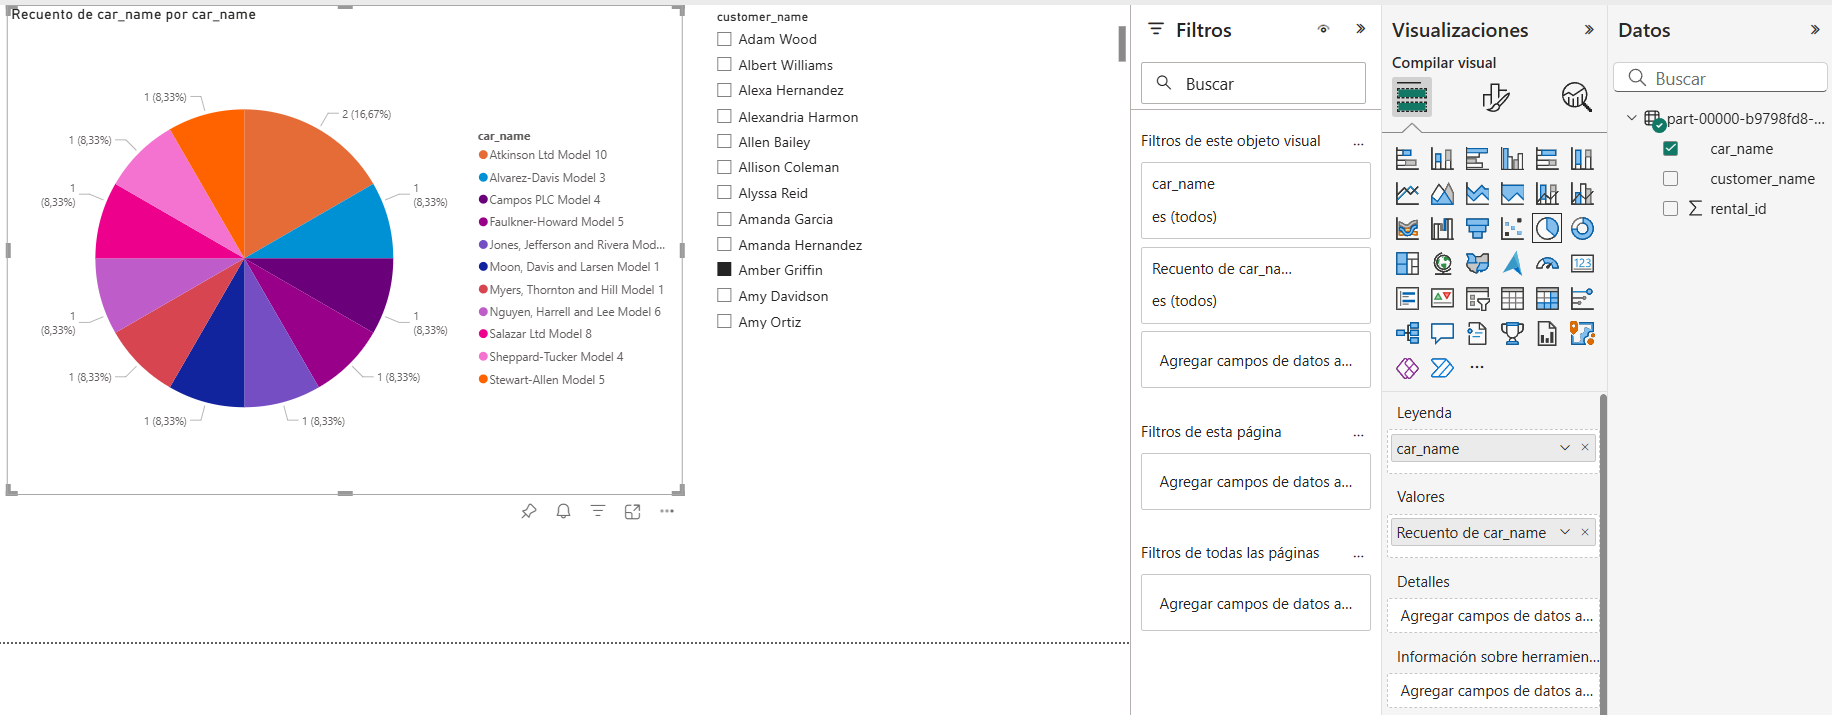